In [16]:
import numpy as np 
import pandas as pd 
import optuna 
from catboost import CatBoostClassifier,Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score,accuracy_score, confusion_matrix, classification_report,precision_score,f1_score,average_precision_score,roc_auc_score,make_scorer
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
PROJECT_ROOT = Path.cwd().parent
os.chdir(PROJECT_ROOT)

In [3]:
X = pd.read_csv("data/fe/X_train_fe.csv")
y = pd.read_csv("data/fe/y_train.csv").squeeze()

In [4]:
cat_features = [X.columns.get_loc(c) for c in ["Sex", "Embarked", "Title"]]

In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(recall_score)

In [20]:
def objective(trial: optuna.Trial) ->float:
    params = {
        "loss_function": "Logloss",
        "eval_metric": 'Recall',#Либо AUC
        "random_seed": 42,
        "verbose": 0,
        #Гиперпараметры
        "iterations":trial.suggest_int("iterations", 300, 1500),
        "learning_rate":trial.suggest_float("learning_rate", 0.01, 0.2,log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 50.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0, log=True),
        #регуляризация
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.6, 1.0),
    }
    aucs  = []
    for train_idx,val_idx in cv.split(X,y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
        train_pool = Pool(X_tr, y_tr, cat_features=cat_features)
        val_pool = Pool(X_val, y_val, cat_features=cat_features)
        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=val_pool, use_best_model=True, early_stopping_rounds=50)
        y_score = model.predict_proba(val_pool)[:, 1]
        aucs.append(roc_auc_score(y_val, y_score))
    return float(np.mean(aucs))    
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print("Best CV AUC:", study.best_value)
print("Best params:", study.best_params)
    

[I 2025-12-28 17:31:33,392] A new study created in memory with name: no-name-1d9b08d6-782a-4ce9-b469-a3fe3a522b4e
[I 2025-12-28 17:31:37,297] Trial 0 finished with value: 0.8289240102171137 and parameters: {'iterations': 1406, 'learning_rate': 0.11793375390738318, 'depth': 6, 'l2_leaf_reg': 23.05704656213574, 'random_strength': 9.087067399615623, 'subsample': 0.7334082861822675, 'colsample_bylevel': 0.9487737738304458}. Best is trial 0 with value: 0.8289240102171137.
[I 2025-12-28 17:31:43,209] Trial 1 finished with value: 0.8739657547259428 and parameters: {'iterations': 1081, 'learning_rate': 0.15811058085193164, 'depth': 8, 'l2_leaf_reg': 4.259679267093071, 'random_strength': 0.5161388251963089, 'subsample': 0.7258975597042652, 'colsample_bylevel': 0.8108097515739718}. Best is trial 1 with value: 0.8739657547259428.
[I 2025-12-28 17:31:57,032] Trial 2 finished with value: 0.8680613607337746 and parameters: {'iterations': 1435, 'learning_rate': 0.017810243024758782, 'depth': 10, 'l2_

Best CV AUC: 0.878681723187993
Best params: {'iterations': 901, 'learning_rate': 0.13887471140380872, 'depth': 7, 'l2_leaf_reg': 3.2734803912632304, 'random_strength': 0.0009055471305909781, 'subsample': 0.6886868669530279, 'colsample_bylevel': 0.8311372672797005}


In [21]:
X_test = pd.read_csv("data/fe/X_test_fe.csv")
y_test = pd.read_csv("data/fe/y_test.csv").squeeze()


In [30]:
best_params = study.best_params
final_params = {
    "loss_function": "Logloss",
    "eval_metric": "Recall",
    "random_seed": 42,
    "verbose": 100,
    **best_params
}

In [31]:
train_pool = Pool(X, y, cat_features=cat_features)
test_pool  = Pool(X_test, y_test, cat_features=cat_features)

In [32]:
final_model = CatBoostClassifier(**final_params)
final_model.fit(train_pool)

0:	learn: 0.6923077	total: 14.5ms	remaining: 13s
100:	learn: 0.8791209	total: 1.67s	remaining: 13.2s
200:	learn: 0.9304029	total: 3.32s	remaining: 11.6s
300:	learn: 0.9597070	total: 4.97s	remaining: 9.91s
400:	learn: 0.9780220	total: 6.62s	remaining: 8.26s
500:	learn: 0.9816850	total: 8.29s	remaining: 6.62s
600:	learn: 0.9926740	total: 9.93s	remaining: 4.96s
700:	learn: 0.9926740	total: 11.6s	remaining: 3.3s
800:	learn: 0.9926740	total: 13.2s	remaining: 1.65s
900:	learn: 0.9963370	total: 14.8s	remaining: 0us


In [33]:
y_score = final_model.predict_proba(test_pool)[:, 1]
print("Test AUC:", roc_auc_score(y_test, y_score))

Test AUC: 0.8484848484848485


In [34]:
y_pred = (y_score >= 0.5).astype(int)
print("Test Recall:", recall_score(y_test, y_pred))
print("Test Precision:", precision_score(y_test, y_pred))
print("Test F1:", f1_score(y_test, y_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test PR-AUC:", average_precision_score(y_test, y_score))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Test Recall: 0.6956521739130435
Test Precision: 0.8421052631578947
Test F1: 0.7619047619047619
Test Accuracy: 0.8324022346368715
Test PR-AUC: 0.8171494734769423
Confusion matrix:
 [[101   9]
 [ 21  48]]


In [35]:
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Confusion matrix:
 [[101   9]
 [ 21  48]]
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       110
           1       0.84      0.70      0.76        69

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



In [36]:
accuracy = accuracy_score(y_test, y_pred)
error_rate = 1 -accuracy
print(f'Точность R^2: {accuracy}')
print(f'Доля ошибочных классификаций: {error_rate}')

Точность R^2: 0.8324022346368715
Доля ошибочных классификаций: 0.16759776536312854


Text(50.722222222222214, 0.5, 'True Label')

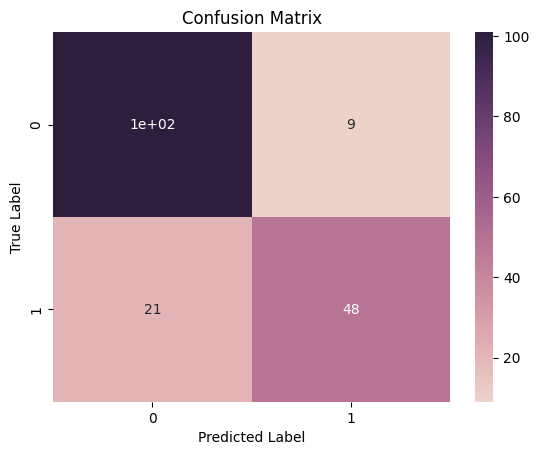

In [37]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')